In [1]:
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import Document
import json
import os
from dotenv import load_dotenv
load_dotenv()

True

### Parcing NOAA's glossary

In [ ]:
import sys
import string
import requests
from bs4 import BeautifulSoup
import re

# A common desktop browser UA to avoid 403
BROWSER_HEADERS = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/115.0.0.0 Safari/537.36'
    )
}

def fetch_html(url):
    """Fetch page HTML with a browser-like User-Agent."""
    resp = requests.get(url, headers=BROWSER_HEADERS, timeout=10)
    resp.raise_for_status()
    return resp.text

def parse_glossary_improved(html):
    """Extract term/definition pairs from NOAA glossary page HTML."""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Find the main content area
    # The content seems to be in the body after navigation elements
    content = soup.find('body')
    if not content:
        return []
    
    # Get all text content and process it
    text_content = content.get_text()
    
    # Split by lines and clean up
    lines = [line.strip() for line in text_content.split('\n') if line.strip()]
    
    entries = []
    current_term = None
    current_definition = []
    
    # Process lines to identify terms and definitions
    for i, line in enumerate(lines):
        # Skip navigation and header content
        if any(nav_text in line for nav_text in [
            "Weather Glossary:", "Weather Acronyms:", "Appendix", 
            "Glossary", "Downloads", "Acronyms"
        ]):
            continue
            
        # Check if this looks like a term (usually bold/standalone)
        # Terms are typically short and followed by definitions
        if (len(line) < 100 and  # Terms are usually shorter
            not line.endswith('.') and  # Definitions usually end with periods
            not line.startswith('The ') and  # Definitions often start with "The"
            not line.startswith('A ') and   # Definitions often start with "A"
            not line.startswith('An ') and  # Definitions often start with "An"
            i + 1 < len(lines) and  # Make sure there's a next line
            len(lines[i + 1]) > 20):  # Next line looks like a definition
            
            # Save previous term if we have one
            if current_term and current_definition:
                definition_text = ' '.join(current_definition).strip()
                if definition_text:
                    entries.append({
                        'term': current_term,
                        'definition': definition_text
                    })
            
            # Start new term
            current_term = line
            current_definition = []
        else:
            # This is part of a definition
            if current_term:
                current_definition.append(line)
    
    # Don't forget the last term
    if current_term and current_definition:
        definition_text = ' '.join(current_definition).strip()
        if definition_text:
            entries.append({
                'term': current_term,
                'definition': definition_text
            })
    
    return entries

def parse_glossary_by_structure(html):
    """Alternative parsing method looking for specific HTML structure."""
    soup = BeautifulSoup(html, 'html.parser')
    entries = []
    
    # Try to find all list items or similar structures
    # Look for patterns where terms might be defined
    
    # Find all strong/bold elements (often used for terms)
    strong_elements = soup.find_all(['strong', 'b'])
    
    for strong in strong_elements:
        term_text = strong.get_text(strip=True)
        if not term_text or len(term_text) > 100:
            continue
            
        # Look for definition text following the term
        definition_parts = []
        current = strong.next_sibling
        
        # Collect text until we hit another term or end of section
        while current:
            if hasattr(current, 'name'):
                if current.name in ['strong', 'b']:
                    break
                if current.name == 'p':
                    definition_parts.append(current.get_text(strip=True))
                elif current.name in ['li', 'div']:
                    text = current.get_text(strip=True)
                    if text:
                        definition_parts.append(text)
            elif hasattr(current, 'strip'):
                text = current.strip()
                if text and not text.startswith('-'):
                    definition_parts.append(text)
            
            current = current.next_sibling
            
            # Stop if we've collected enough text
            if len(' '.join(definition_parts)) > 500:
                break
        
        definition = ' '.join(definition_parts).strip()
        if definition and len(definition) > 10:
            entries.append({
                'term': term_text,
                'definition': definition
            })
    
    return entries

def parse_glossary_bullet_points(html):
    """Parse assuming bullet point or dash-separated format."""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Get the main text content
    text_content = soup.get_text()
    
    # Split by lines and look for patterns like "- Term" followed by definition
    lines = [line.strip() for line in text_content.split('\n') if line.strip()]
    
    entries = []
    i = 0
    
    while i < len(lines):
        line = lines[i]
        
        # Skip navigation content
        if any(nav_text in line for nav_text in [
            "Weather Glossary:", "Weather Acronyms:", "Appendix", 
            "Glossary", "Downloads", "Acronyms"
        ]):
            i += 1
            continue
        
        # Look for lines that start with "- " (bullet points)
        if line.startswith('- ') and len(line) < 150:
            term = line[2:].strip()  # Remove "- " prefix
            
            # Collect definition from subsequent lines
            definition_lines = []
            i += 1
            
            while i < len(lines) and not lines[i].startswith('- '):
                if lines[i].strip() and not any(nav in lines[i] for nav in ["Weather Glossary:", "Weather Acronyms:"]):
                    definition_lines.append(lines[i].strip())
                i += 1
            
            if definition_lines:
                definition = ' '.join(definition_lines)
                entries.append({
                    'term': term,
                    'definition': definition
                })
            
            # Don't increment i here since we already did in the while loop
            continue
        
        i += 1
    
    return entries

# Test all three methods
def parse_glossary_comprehensive(html):
    """Try multiple parsing approaches and return the best result."""
    
    # Method 1: Bullet point parsing
    result1 = parse_glossary_bullet_points(html)
    
    # Method 2: Structure-based parsing  
    result2 = parse_glossary_by_structure(html)
    
    # Method 3: Your original method (modified)
    soup = BeautifulSoup(html, 'html.parser')
    result3 = []
    
    # Look for any dl elements
    for dl in soup.find_all('dl'):
        for dt in dl.find_all('dt'):
            term = dt.get_text(strip=True)
            if not term:
                continue
                
            definition_parts = []
            for sibling in dt.find_next_siblings():
                if sibling.name == 'dt':
                    break
                if sibling.name == 'dd':
                    definition_parts.append(sibling.get_text(strip=True))
            
            full_definition = " ".join(definition_parts)
            if full_definition:
                result3.append({'term': term, 'definition': full_definition})
    
    # Return the method that found the most entries
    results = [result1, result2, result3]
    best_result = max(results, key=len)
    
    
    return best_result

In [ ]:

all_letters = {}
for letter in string.ascii_lowercase:
    url = f'https://www.noaa.gov/jetstream/appendix/weather-glossary-{letter}'
    try:
        html = fetch_html(url)
        glossary = parse_glossary_comprehensive(html)
        if glossary:
            all_letters[letter] = glossary
        else:
            print(f"Warning: no entries found for '{letter}'")
    except requests.HTTPError as e:
        print(f"HTTP error for {url}: {e}")
    except Exception as e:
        print(f"Error processing {letter}: {e}")

In [ ]:
output_path = 'noaa_glossary1.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(all_letters, f, ensure_ascii=False, indent=2)

## On Jupyterhub (without downloading LLM)

### 🔑 Setting Up API Tokens

Before working with LLMs, you'll need to obtain API tokens from key services (it's FREE):

#### Hugging Face Token
1. Visit [huggingface.co](https://huggingface.co) and create an account
2. Go to **Settings** → **Access Tokens**
3. Click **"New token"** → Choose **"Read"** access
4. Copy the token (starts with `hf_...`)

#### LangSmith API Key (Optional - for debugging)
1. Visit [smith.langchain.com](https://smith.langchain.com)
2. Sign up with GitHub/Google
3. Go to **Settings** → **API Keys**
4. Click **"Create API Key"**
5. Copy the key (starts with `ls__...`)

#### Create a .env file

Create a `.env` file in your project directory with your tokens:

```bash
HF_TOKEN=hf_your_token_here
LANGCHAIN_API_KEY=ls__your_key_here
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT='https://api.smith.langchain.com'
```

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

In [3]:
HF_TOKEN = os.environ["HF_TOKEN"]

# Initialize the LLM with correct model format for Hugging Face router
llm = ChatOpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=HF_TOKEN,
    model="openai/gpt-oss-20b:fireworks-ai"  
)

# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AI assistant."),
    ("human", "{question}")
])

# Create the chain with output parser
chain_no_context = prompt | llm | StrOutputParser()

In [ ]:
# Invoke the chain
response = chain_no_context.invoke({"question": "Hello there"})
print(response)

### Creating RAG

In [6]:
with open("noaa_glossary1.json", "r", encoding="utf-8") as f:
    data = json.load(f)
docs = []
for letter, entries in data.items():
    for entry in entries:
        # use the definition as the content, and keep the term (and letter) as metadata
        docs.append(
            Document(
                page_content=entry["term"] + entry["definition"],
                metadata={"term": entry["term"], "letter": letter}
            )
        )

In [7]:
docs_cut = docs[1::3]

In [8]:
from langchain_huggingface import HuggingFaceEndpointEmbeddings
doc_embedder = HuggingFaceEndpointEmbeddings(
    model="Qwen/Qwen3-Embedding-8B",
    task="feature-extraction",
    model_kwargs={"normalize": True},
)

In [9]:
vector_store_hf = Chroma.from_documents(docs_cut, doc_embedder)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AI assistant that answers users’ questions by consulting the NOAA weather glossary as your primary reference. "),
    ("human", "{question}")
])
retriever = vector_store_hf.as_retriever()
chain_context = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    condense_question_prompt=prompt
)


In [10]:
result = chain_context({"question":  "What is Stratus?","chat_history": []})
print(result)

/tmp/ipykernel_53/3246132003.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain_context({"question":  "What is Stratus?","chat_history": []})


{'question': 'What is Stratus?', 'chat_history': [], 'answer': 'Stratus (St) is a type of low‑level cloud that forms a uniform, sheet‑like layer. It typically blankets the sky between the ground and about 6,500\u202fft (≈2,000\u202fm) high, has no distinct cloud elements like cumulus, and often looks plain and gray. The cloud is mostly composed of water vapor. When a stratus cloud’s base touches the ground, it becomes **fog**.'}


In [11]:
response = chain_no_context.invoke({"question": "What is Stratus?"})
print(response)

**Stratus** can refer to several things depending on the context. Here are the most common uses:

| Context | What it means |
|--------|------------------|
| **Meteorology** | *Stratus* (plural *stratums*) is a type of cloud that forms a flat, low‑lying layer, often covering large portions of the sky. It usually appears as a gray or white blanket and often brings light rain or drizzle. |
| **Cloud Computing / SaaS** | **Stratus** is a popular naming convention in the tech industry for platforms that deliver on‑demand services (think of “cloud” as the sky of computing). Companies use the name to evoke the idea of “cloud‑based” infrastructure and services, often with a focus on simplicity, elasticity, and cost efficiency. |
| **Stratus, Inc.** | A U.S. software‑services company that provides hosted infrastructure, security, and business‑process solutions, primarily for small and medium‑size businesses. |
| **Other Companies / Products** | Several small firms, labs, and software tools ado

## On your Computer/Laptop (downloading LLM)

In [12]:
import os
print(f"Total RAM: {os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024 ** 3):.2f} GB")

Total RAM: 30.89 GB


### Memory Requirements:
Required RAM ≈ Model Parameters × 2 bytes (for 16-bit) + 2-4GB overhead

In [16]:
def calculate_required_ram(model_params, overhead_gb=2):
    """
    Calculate required RAM for a model.
    Args:
        model_params (int): Number of model parameters (in billions).
        overhead_gb (int): Overhead in GB (default 2GB).
    Returns:
        float: Required RAM in GB.
    """
    # Convert model_params from billions to actual number
    params = model_params * 1_000_000_000
    ram_bytes = params * 2
    ram_gb = ram_bytes / (1024 ** 3)
    total_ram_gb = ram_gb + overhead_gb
    return total_ram_gb

# List of model parameters in billions
model_params_list = [1, 4, 7, 27, 32, 70, 671]

print("Model Parameters (B)", "Required RAM (GB, 2GB overhead)", "Required RAM (GB, 4GB overhead)", sep="\t")
for params in model_params_list:
    ram_2gb = calculate_required_ram(params, overhead_gb=2)
    ram_4gb = calculate_required_ram(params, overhead_gb=4)
    print(f"{params}\t\t\t{ram_2gb:.2f}\t\t\t{ram_4gb:.2f}")

Model Parameters (B)	Required RAM (GB, 2GB overhead)	Required RAM (GB, 4GB overhead)
1			3.86			5.86
4			9.45			11.45
7			15.04			17.04
27			52.29			54.29
32			61.60			63.60
70			132.39			134.39
671			1251.83			1253.83


<img src="./llm_arena.png" alt="drawing" width="1200"/>

### Install LLM on your laptop (not on JupyterHub)

Follow these steps in your terminal:

**Install Ollama on your Mac:**
   ```bash
   brew install ollama
   ```
**Install Ollama on Windows**  
Download the installer from the [Ollama website](https://ollama.com/)


**Run the model (if you have a GPU):**
   ```bash
   ollama run gemma3:4b
   ```

**Run the model (if you don't have a GPU):**
   ```bash
   ollama run gemma3n:e4b
   ```
**embedding model:**
```bash
ollama pull nomic-embed-text:v1.5
```
   

In [ ]:
from langchain_ollama import OllamaLLM
# Initialize the LLM with the model you pulled via Ollama
llm = OllamaLLM(model="gemma3:4b")

In [5]:
from langchain_ollama import OllamaEmbeddings
embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5") 

In [27]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AI assistant."),
    ("human", "{question}")
])

chain_no_context = prompt | llm

In [28]:
response = chain_no_context.invoke({"question": "Hello there"})
print(response)

Hello! How can I help you today?



### Creating RAG

In [3]:
with open("noaa_glossary1.json", "r", encoding="utf-8") as f:
    data = json.load(f)
docs = []
for letter, entries in data.items():
    for entry in entries:
        # use the definition as the content, and keep the term (and letter) as metadata
        docs.append(
            Document(
                page_content=entry["term"] + entry["definition"],
                metadata={"term": entry["term"], "letter": letter}
            )
        )


In [7]:
# Embed & index
vector_store = Chroma.from_documents(docs, embeddings)

In [33]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AI assistant that answers users’ questions by consulting the NOAA weather glossary as your primary reference. "),
    ("human", "{question}")
])
retriever = vector_store.as_retriever(search_kwargs={"k": 1})
chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    condense_question_prompt=prompt
)

In [34]:
result = chain({"question":  "What is Stratus?","chat_history": []})
print(result)

{'question': 'What is Stratus?', 'chat_history': [], 'answer': 'Stratus is a low, uniform sheet-like cloud.\n'}


In [35]:
response = chain_no_context.invoke({"question": "What is Stratus?"})
print(response)

That's a great question! Stratus is a weather phenomenon that occurs when the sky becomes unusually thick and heavy, often with a thin layer of clouds. It's a sign that the weather is approaching a potentially sunny day.



## Tools and Agents

<img src="./agent_pic.png" alt="drawing" width="600"/>


In [4]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
import xarray as xr
from arraylake import Client

In [17]:
openai_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0) # - optional 

#### ERA5 retrieving tool

In [5]:

def extract_era5_data(
    variable: str,
    time_start: str,
    time_end: str,
    lat_min: float = -90,
    lat_max: float = 90,
    lon_min: float = 0,
    lon_max: float = 360,
):
    client = Client()
    repo = client.get_repo("earthmover-public/era5-surface-aws")
    session = repo.readonly_session("main")
    ds_spatial = xr.open_dataset(
        session.store,
        engine="zarr",
        consolidated=False,
        zarr_format=3,
        chunks=None,
        group="spatial",
    )
    sel = ds_spatial[variable].sel(
        time=slice(time_start, time_end),
        latitude=slice(lat_max, lat_min),  # ERA5 is north-to-south
        longitude=slice(lon_min, lon_max)
    )
    filename = f"./tmp/{variable}_{time_start}_{time_end}_{lat_min}_{lat_max}_{lon_min}_{lon_max}.nc"
    print_message = f'filename to use: {filename}'
    sel.to_netcdf(filename)
    return sel, print_message

In [6]:
from typing import Optional, Literal
from pydantic import BaseModel, Field, conint, confloat
from langchain_core.tools import StructuredTool

# 1. Define the Pydantic schema for structured args, with variable restricted to allowed values
class ERA5Params(BaseModel):
    variable: Literal[
        "blh",   # Boundary layer height
        "d2",    # 2 metre dewpoint temperature
        "cape",  # Convective available potential energy
        "sd",    # Snow depth
        "sp",    # Surface pressure
        "sst",   # Sea surface temperature
        "skt",   # Skin temperature
        "stl1",  # Soil temperature level 1
        "tcc",   # Total cloud cover
        "swvl1", # Volumetric soil water layer 1
        "t2",    # 2 metre temperature
        "tcwv",  # Total column water vapour
        "tcw",   # Total column water
        "u10",   # 10 metre U wind component
        "mslp",  # Mean sea level pressure
        "u100",  # 100 metre U wind component
        "v10",   # 10 metre V wind component
        "v100"   # 100 metre V wind component
    ] = Field(
        ...,
        description=(
            "ERA5 variable to extract; one of:\n"
            "'blh' (Boundary layer height),\n"
            "'d2' (2 metre dewpoint temperature),\n"
            "'cape' (Convective available potential energy),\n"
            "'sd' (Snow depth),\n"
            "'sp' (Surface pressure),\n"
            "'sst' (Sea surface temperature),\n"
            "'skt' (Skin temperature),\n"
            "'stl1' (Soil temperature level 1),\n"
            "'tcc' (Total cloud cover),\n"
            "'swvl1' (Volumetric soil water layer 1),\n"
            "'t2' (2 metre temperature),\n"
            "'tcwv' (Total column water vapour),\n"
            "'tcw' (Total column water),\n"
            "'u10' (10 metre U wind component),\n"
            "'mslp' (Mean sea level pressure),\n"
            "'u100' (100 metre U wind component),\n"
            "'v10' (10 metre V wind component),\n"
            "'v100' (100 metre V wind component)"
        )
    )
    time_start: str = Field(
        ..., description="ISO timestamp, e.g. '2000-01-01T00:00:00'"
    )
    time_end: str = Field(
        ..., description="ISO timestamp, e.g. '2000-01-02T00:00:00'"
    )
    lat_min: confloat(ge=-90, le=90) = Field(
        ..., description="Southern latitude bound, between -90 and 90"
    )
    lat_max: confloat(ge=-90, le=90) = Field(
        ..., description="Northern latitude bound, between -90 and 90"
    )
    lon_min: confloat(ge=0, le=360) = Field(
        ..., description="Western longitude bound, between 0 and 360"
    )
    lon_max: confloat(ge=0, le=360) = Field(
        ..., description="Eastern longitude bound, between 0 and 360"
    )

# 2. Wrap the existing extract_era5_data function into a structured LangChain Tool
era5_tool = StructuredTool.from_function(
    extract_era5_data,
    name="era5_data_extractor",
    description=(
        "Extract ERA5 reanalysis data from the Earthmover Zarr store using arraylake. "
        "Requires variable, time_start, time_end, optional level, and lat/lon bounds., lat from -90 to 90, lon from 0 to 360"
    ),
    args_schema=ERA5Params,
)

#### Python repl tool

In [7]:
python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description=(
        "A Python REPL. Use to execute matplotlib code for plotting. "
        "Input must be valid Python; use print(...) or plt.show() to display output."
        "Do NOT mock the data. Use filename from era5_tool to open netcdf file"
        "Use cmocean for colormaps"
        "Use cartopy for continents if needed"
    ),
    func=python_repl.run,
)
# agent_executor = create_react_agent(llm,[repl_tool, era5_tool])

In [8]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.prompts import MessagesPlaceholder

# Use your existing tools
tools = [repl_tool, era5_tool]

# Create the LLM

# System & user prompt for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert in ERA5 data analysis that can use era5_tool to download the data and repl_tool to perform plots"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
llm = ChatOpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=HF_TOKEN,
    model="openai/gpt-oss-120b:fireworks-ai"  
)



In [9]:
# Define the agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
)

# Create the executor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `era5_data_extractor` with `{'variable': 'sst', 'time_start': '2015-08-26T00:00:00', 'time_end': '2015-08-27T00:00:00', 'lat_min': -90, 'lat_max': -30, 'lon_min': 0, 'lon_max': 360}`


(<xarray.DataArray 'sst' (time: 25, latitude: 241, longitude: 1440)> Size: 35MB
array([[[290.39746, 290.30566, ..., 290.70996, 290.58887],
        [290.3252 , 290.3252 , ..., 290.63867, 290.50098],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[290.39746, 290.30566, ..., 290.70996, 290.58887],
        [290.3252 , 290.3252 , ..., 290.63867, 290.50098],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[290.29004, 290.2539 , ..., 290.61133, 290.46484],
        [290.18945, 290.23535, ..., 290.54102, 290.37207],
        ...,
        [      nan,       nan, ...,   

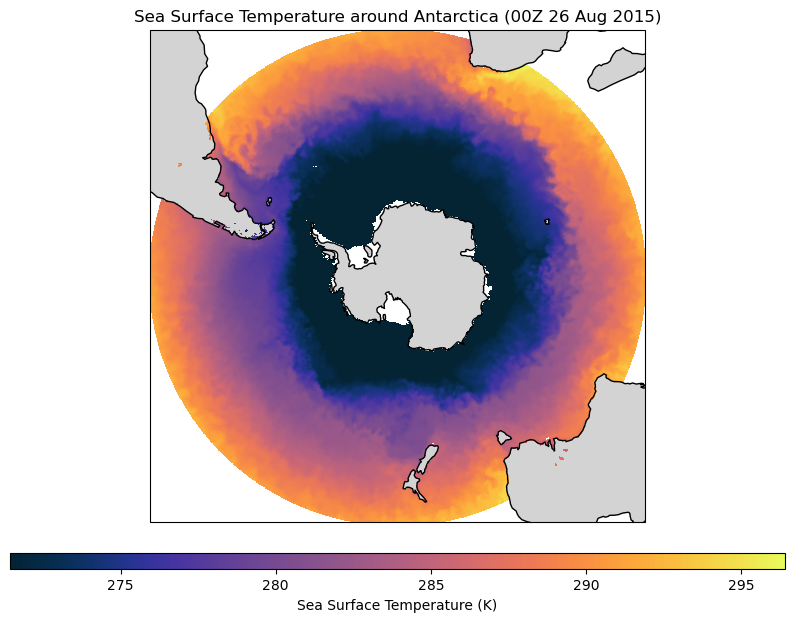

Here is the SST map for the Southern Ocean (latitudes –90 ° to –30 °) on 26 August 2015 (00 UTC). The plot uses a polar‑stereographic projection, the **cmocean** “thermal” colormap, and includes coastlines for context.  

![Sea Surface Temperature around Antarctica on 2015‑08‑26](attachment://output.png)

> Finished chain.


In [13]:
result = agent_executor.invoke({"input": "Plot SST around Antarctic until 30S on August 26 2015"})